In [86]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from datetime import datetime
from typing import Optional, TextIO
import sys

In [87]:
DEVICE = torch.device("cpu") # No point in using MPS for now :( See https://github.com/pytorch/pytorch/issues/77799

## NN Utilities

In [88]:
def plot_losses_over_epochs(train_losses: list[float], valid_losses: list[float]):
    '''
    Graphically show the training and validation loss for each epoch.
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [89]:
def run_single_epoch(loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class = 1, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() 
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, Y_true in loader:
        X = normalize_input_fn(X) # Normalizing the input if necessary
        X = X.to(DEVICE)
        Y_true = Y_true.to(DEVICE)
        # Y_true = normalize_labels_fn(Y_true)
        # Y_true[Y_true == positive_class]  = 1 # We "normalize" the label of the positive class to be "1". Makes our lives easier (see comment below)
        
        optimizer.zero_grad() if train else None
        
        # Forward pass
        Y_logits, Y_prob = model(X)
        _, predicted_labels = torch.max(Y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in.
                                                        # This actually returns the indices of the highest prediction for each row, 
                                                        # but since the index is one-to-one with the predicted digit (i.e., 0 or 1), 
                                                        # we use the index of the max probability as the label that's being predicted
        batch_loss = criterion(Y_logits, Y_true) # we use the logits as the parameter since "CELoss already pefroms softmax internally.
        running_loss += batch_loss.item() * X.size(0) # X.size(0) is the size of the BATCH, not the image. 
                                                # The multiplication is required later for calculating the avg loss of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            batch_loss.backward()
            optimizer.step()
    
    avg_batch_loss_for_epoch = running_loss / len(loader.dataset)
    return model, optimizer, avg_batch_loss_for_epoch

In [90]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, positive_class=1, num_epochs=10, normalize_input_fn=lambda x: x, 
             normalize_labels_fn=lambda y: y, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        # print(f'Epoch: {epoch}\t')
        
        # Training the model
        _, _, train_loss = run_single_epoch(train_loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class)
        train_losses.append(train_loss)
        
        # No need for validation when working with a score model
        validation_losses.append(0)
        # # Validation
        # with torch.no_grad():
        #     _, _, validation_loss = run_single_epoch(validation_loader, criterion, model, None, normalize_input_fn, normalize_labels_fn, positive_class, False)
        #     validation_losses.append(validation_loss)
        
        # if epoch % print_every == (print_every - 1):
        #     print(f'{datetime.now().time().replace(microsecond=0)} --- '
        #           f'Epoch: {epoch}\t'
        #           f'Train loss: {train_loss:.4f}\t'
        #           # f'Vaildation loss: {validation_loss:.4f}\t')
        #           f'Vaildation loss: 0\t')
    
    plot_losses_over_epochs(train_losses, validation_losses)
        
    return model, optimizer, num_epochs, (train_losses, validation_losses)

### Models

In [91]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


In [92]:
class SimpleDataSet(Dataset):
    def __init__(self, data, targets):
        super(SimpleDataSet, self).__init__()
        assert data.shape[0] == targets.shape[0] # assuming shape[0] = dataset size
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.targets[index].item()

In [93]:
class EncodeBasedLikelihoodRatioModel():
    def __init__(self, vae, null_mv, positive_mv):
        self.vae = vae
        self.null_mv = null_mv
        self.positive_mv = positive_mv
    
    def __call__(self, value):
        mu_logvar = self.vae.encoder(value.view(-1, 1024)).view(-1, 2, LATENT_DIM)
        mu = mu_logvar[:, 0, :]
        llr = self.positive_mv.log_prob(mu) - self.null_mv.log_prob(mu)
        # We need a 0s "column as the first col to represent the probability of the "null" class (same as LeNet result)
        llr_0_padded_right = torch.stack((torch.zeros(llr.view(-1,1).shape[0]).view(-1,1),llr.view(-1,1)), dim=1).squeeze()
        return None, llr_0_padded_right
    
    def eval(self):
        pass

class LikelihoodRatioModel():
    def __init__(self, null_mv, positive_mv):
        self.null_mv = null_mv
        self.positive_mv = positive_mv
    
    def __call__(self, value):
        llr = self.positive_mv.log_prob(value) - self.null_mv.log_prob(value)
        # We need a 0s "column as the first col to represent the probability of the "null" class (same as LeNet result)
        llr_0_padded_right = torch.stack((torch.zeros(llr.view(-1,1).shape[0]).view(-1,1),llr.view(-1,1)), dim=1).squeeze()
        return None, llr_0_padded_right
    
    def eval(self):
        pass

## Samples Generation

In [94]:
LATENT_DIM = 5

class VAEFC(nn.Module):
    '''
    A fully-connectec variational autoencoder (as opposed to convolution-based) used as generative model for MNIST.
    '''

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, LATENT_DIM * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 1024),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 1024)).view(-1, 2, LATENT_DIM)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

In [95]:
def vae_loss_for_single_element_batch(x_hat, x, mu, logvar, y=None, β=3):
    '''
    'Dynamic' loss: changes based on the type of MNIST digit. This forces the VAE to place each digit near the mean we want, effectively
    creating a mixture model of normals.

    IMPORTANT: THIS WILL ONLY WORK WITH BATCH_SIZE=1 because otherwise the loss will not be calculated correctly.
    '''
    base_loss = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 1024), reduction='sum'
    )
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)) # Orig KLD
    
    # KLD(p,q) = KL(N(m1,s1), N(m2,s2)) = log(std2/std1) + (s1 + ((m1-m2)^2))/(2*s2) - 1/2    , where s is VARIANCE (not STD), std1=sqrt(s1)
    KLD = 0
    if y[0]==4:
        KLD = 0.5 * torch.sum(logvar.exp() - logvar + (mu-1).pow(2) -1)
    else:
        KLD = 0.5 * torch.sum(logvar.exp() - logvar + (mu+1).pow(2) -1)
    return base_loss + β * KLD

In [96]:
# Define data loading step

class_map = {"null": 4, "positive": 9}
labels_map = {4:0, 9:1} 

def get_loader_for_vae(dataset, class_to_load=None, batch_size=1, num_samples=None):
    if class_to_load is None:
        samples_index = torch.logical_or(dataset.targets == class_map["null"] ,dataset.targets == class_map["positive"]).nonzero().reshape(-1)
    else:
        samples_index = (dataset.targets == class_map[class_to_load]).nonzero().reshape(-1)
    if num_samples is not None:
        samples_index = samples_index[:num_samples]
    print(F"sample index: {samples_index.shape}")
    return DataLoader(dataset,batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(samples_index), drop_last=True)

In [100]:
def train_VAE(vae, train_loader, vae_criterion, epochs=10):
    
    learning_rate = 1e-3
    
    vae_optimizer = torch.optim.Adam(
        vae.parameters(),
        lr=learning_rate,
    )
    
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        print(f'====> VAE Epoch: {epoch}')
        for x, label in train_loader:
            x = x.to(DEVICE)
            # ===================forward=====================
            x_hat, mu, logvar = vae(x)
            loss = vae_criterion(x_hat, x, mu, logvar, label)
            train_loss += loss.item()
            # ===================backward====================
            vae_optimizer.zero_grad()
            loss.backward()
            vae_optimizer.step()
        # ===================log========================
        print(f'VAE Average loss: {train_loss / len(train_loader.dataset):.4f}')

In [101]:
from typing import TypedDict

VAECodes = TypedDict('VAECodes', {'mu': torch.Tensor, 'logvar': torch.Tensor, 'label': torch.Tensor})

def get_VAE_codes_for_samples(vae: torch.nn.Module, loader: torch.utils.data.DataLoader) -> VAECodes: 
    codes = dict(mu=list(), logvar=list(), label=list())
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        vae.eval()
        for x, y in loader:
            x = x.to(DEVICE)
            # ===================forward=====================
            x_hat, mu, logvar = vae(x)
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'] = torch.cat(means)
    codes['logvar']= torch.cat(logvars)
    codes['label'] = torch.cat(labels)
    return codes

In [102]:
def get_mean_and_vcov_for_vae_codes(codes: VAECodes):
        mean_tensor = codes['mu'].mean(0)
        centered_mus = codes['mu'] - mean_tensor
        vcov = centered_mus.T.cov()
        return dict(mean=mean_tensor, vcov=vcov, centered_mus=centered_mus)

In [103]:
VAEResult = TypedDict('VAEResult', {'vae': torch.nn.Module, 'null_mean': torch.Tensor, 'positive_mean':torch.Tensor, 'common_vcov': torch.Tensor})

image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

def get_trained_vae() -> torch.nn.Module:
    '''
    Returns: an MNIST-trained VAE.
    '''
    # Loading relevant data
    train_all_loader = get_loader_for_vae(MNIST('./data', train=True, download=True, transform=image_padding_to_32))

    # Create and train the VAE
    vae = VAEFC().to(DEVICE)
    train_VAE(vae, train_all_loader, vae_loss_for_single_element_batch)
    
    return vae


def get_vae_stats(vae: torch.nn.Module):
    '''
    Parameters:
        vae: The MNIST-trained VAE to get the stats from.
    
    Returns:
        a Dictionary of the form: {null_mean: torch.Tensor, positive_mean: torch.Tensor, common_vcov: torch.Tensor} 
    '''
    # Loading relevant data
    train_null_only = get_loader_for_vae(MNIST('./data', train=True, download=True, transform=image_padding_to_32), class_to_load="null")
    train_positive_only = get_loader_for_vae(MNIST('./data', train=True, download=True, transform=image_padding_to_32), class_to_load="positive")
    
    # get codes for null and positive classes
    null_codes = get_VAE_codes_for_samples(vae, train_null_only)
    positive_codes = get_VAE_codes_for_samples(vae, train_positive_only)
    
    # get the interesting stats to be used for the generation later
    null_stats = get_mean_and_vcov_for_vae_codes(null_codes)
    positive_stats = get_mean_and_vcov_for_vae_codes(positive_codes)
    
    # calculate common vcov matrix (we want this so that the likelihood ratio will translate to LDA).
    all_centered_means = torch.cat((null_stats['centered_mus'], positive_stats['centered_mus']))
    common_vcov= all_centered_means.T.cov()
    
    return dict(null_mean=null_stats['mean'], positive_mean=positive_stats['mean'], common_vcov=common_vcov)
    
    
def get_trained_vae_and_stats() -> VAEResult:
    vae = get_trained_vae()
    stats = get_vae_stats(vae)
    return dict(vae=vae, null_mean=stats['null_mean'], positive_mean=stats['positive_mean'], common_vcov=stats['common_vcov'])

In [104]:
def get_generated_datasets_from_vae(vae: torch.nn.Module, null_mv: torch.distributions.MultivariateNormal, positive_mv: torch.distributions.MultivariateNormal):
    
    TRAINING_SIZE = 4000
    TEST_NULL_SIZE = 1000
    TEST_POSITIVE_SIZE = 1000
    BENCHMARK_NULL_SIZE = 2000
    BENCHMARK_POSITIVE_SIZE = 2000
    with torch.no_grad():
        vae.eval()
        
        # Training set (only 4s)
        training_codes = null_mv.sample(torch.Size([TRAINING_SIZE]))
        training_data = vae.decoder(training_codes).unsqueeze(dim=1).view(-1,1,32,32)
        training_targets = torch.repeat_interleave(torch.tensor([0]), TRAINING_SIZE)
        training_set = SimpleDataSet(training_data, training_targets)

        # Benchmark set (4 and 9s)
        benchmark_null_codes = null_mv.sample(torch.Size([BENCHMARK_NULL_SIZE]))
        benchmark_positive_codes = positive_mv.sample(torch.Size([BENCHMARK_POSITIVE_SIZE]))
        benchmark_codes = torch.cat((benchmark_null_codes, benchmark_positive_codes)) 
        benchmark_null_targets = torch.repeat_interleave(torch.tensor([0]), BENCHMARK_NULL_SIZE)
        benchmark_positive_targets = torch.repeat_interleave(torch.tensor([1]), BENCHMARK_POSITIVE_SIZE)
        benchmark_targets = torch.cat((benchmark_null_targets, benchmark_positive_targets)) 
        shuffle = torch.randperm(BENCHMARK_NULL_SIZE + BENCHMARK_POSITIVE_SIZE) # we want mixed, random-ordered samples
        benchmark_codes = benchmark_codes[shuffle]
        benchmark_targets = benchmark_targets[shuffle]
        benchmark_data = vae.decoder(benchmark_codes).unsqueeze(dim=1).view(-1,1,32,32)
        benchmark_set = SimpleDataSet(benchmark_data, benchmark_targets)


        # Test set (4 and 9s)
        test_null_codes = null_mv.sample(torch.Size([TEST_NULL_SIZE]))
        test_positive_codes = positive_mv.sample(torch.Size([TEST_POSITIVE_SIZE]))
        test_codes = torch.cat((test_null_codes, test_positive_codes)) 
        test_null_targets = torch.repeat_interleave(torch.tensor([0]), TEST_NULL_SIZE)
        test_positive_targets = torch.repeat_interleave(torch.tensor([1]), TEST_POSITIVE_SIZE)
        test_targets = torch.cat((test_null_targets, test_positive_targets)) 
        shuffle = torch.randperm(TEST_NULL_SIZE + TEST_POSITIVE_SIZE) # we want mixed, random-ordered samples
        test_codes = test_codes[shuffle]
        test_targets = test_targets[shuffle]
        test_data = vae.decoder(test_codes).unsqueeze(dim=1).view(-1,1,32,32)
        test_set = SimpleDataSet(test_data, test_targets)

        return training_set, test_set, benchmark_set, training_codes, test_codes

### Training

In [105]:
def get_trained_model(train_loader, test_loader, num_epochs=20):
    LEARNING_RATE = 1e-3
    N_CLASSES = 2
    
    model = nn.DataParallel(LeNet5(N_CLASSES)) # We create the model from scratch for each experiment
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    return run_loop(train_loader, test_loader, criterion, model, optimizer, normalize_input_fn=lambda x: x / 255.0, num_epochs=num_epochs)

In [106]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        super(ConcatDataset, self).__init__()
        self.datasetA = datasetA
        self.datasetB = datasetB

    def __getitem__(self, i):
        if i<len(self.datasetA):
            return self.datasetA[i]
        else:
            return self.datasetB[i-len(self.datasetA)]

    def __len__(self):
        return (len(self.datasetA) + len(self.datasetB))

In [107]:
import copy

def clone_and_new_computation_graph(t: torch.Tensor, requires_grad=True) -> torch.Tensor:
    '''
        Returns: 
            A Tensor with the same data (copied) as `t`, on a new computation graph
    '''
    t2 = torch.detach(t).clone()
    if requires_grad:
        t2.requires_grad_()
    return t2


def get_synthetic_h0_h1(training_set: SimpleDataSet, test_set: SimpleDataSet, training_codes: torch.Tensor, test_codes: torch.Tensor) -> tuple[SimpleDataSet, SimpleDataSet, SimpleDataSet, int, Optional[torch.Tensor], Optional[torch.Tensor]]:
    '''
    Parameters:
        Training and Test datasets. Each of the following form:
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    Returns:
        H0, H1, H1 with true target values (used for validation), K
    '''
    
    # k = math.floor(len(training_set) / 2) # TODO sample random k instead?
    k = len(training_set)- len(test_set) # TODO sample random k instead?
    # k = len(training_set) - 50
    original_training_data = training_set.data
    original_training_targets = training_set.targets

    # Create H0 set by *copying* the training set, and have it use a separate computation graph.
    h0_data = clone_and_new_computation_graph(original_training_data[:k])
    h0_codes = training_codes[:k] if training_codes is not None else None
    h0_targets = clone_and_new_computation_graph(original_training_targets[:k], requires_grad=False)
    h0_targets[:] = 0

    h0_set = SimpleDataSet(h0_data, h0_targets)
    
    # Create H1 and H1_true_targets sets by *copying* the data and have it use a separate computation graph
    h1_0_data = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_codes = training_codes[k:] if training_codes is not None else None
    h1_0_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    h1_0_targets[:] = 1
        
    h1_0_data_for_true_targets = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_true_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    
    original_test_data = test_set.data
    original_test_targets = test_set.targets
    h1_1_data = clone_and_new_computation_graph(original_test_data)
    h1_1_codes = test_codes if test_codes is not None else None
    h1_1_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    h1_1_targets[:] = 1
    
    h1_1_data_for_true_targets = clone_and_new_computation_graph(original_test_data)
    h1_1_true_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    
    h1_data = torch.cat((h1_0_data, h1_1_data), 0)
    h1_codes = torch.cat((h1_0_codes, h1_1_codes)) if test_codes is not None else None
    h1_targets = torch.cat((h1_0_targets, h1_1_targets), 0)
    
    h1_set = SimpleDataSet(h1_data, h1_targets)
    
    h1_data_true = torch.cat((h1_0_data_for_true_targets, h1_1_data_for_true_targets), 0)
    h1_targets_true = torch.cat((h1_0_true_targets, h1_1_true_targets), 0)
    
    h1_set_with_true_targets = SimpleDataSet(h1_data_true, h1_targets_true)
    

    return h0_set, h1_set, h1_set_with_true_targets, k, h0_codes, h1_codes

In [108]:
def get_datasets_for_discovery(experiment_type: int, add_noise=False) -> tuple[SimpleDataSet, SimpleDataSet]:
    '''
    Parameters:
        experiment_type:
            1 - test data is only H1, no noise
            2 - test data is a mix of H0 and H1, no noise
            
    Returns:
        A Tuple of (training_set, test_set, benchmark_set)
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    '''
    
    BENCHMARK_TRAINING_SIZE = 1000 # data used for training a *standard* classifier for benchmark purposes
    
    image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
    
    if add_noise:
        raise NotImplementedError("Adding noise was not yet implemented")
        
    ## Training data
    training_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
    training_subset_index = (training_set_full.targets == 4).nonzero().reshape(-1)
    training_subset_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(training_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(training_subset_index))
    training_subset_data, training_subset_targets = next(iter(training_subset_loader)) # We only need one iteration, as the loader has the size of the entire relevant sample

    assert len(training_subset_targets[(training_subset_targets!=4).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    
    training_subset_targets[(training_subset_targets==4).nonzero().reshape(-1)] = 0  # Set the targets' value to 0 (as this is our "null" class).

    # Separating training for Adadetect and benchmark
    benchmark_four_subset_data = training_subset_data[-BENCHMARK_TRAINING_SIZE:]
    benchmark_four_subset_targets = training_subset_targets[-BENCHMARK_TRAINING_SIZE:]
    
    # Notice that since we update training_subset_data itself, this MUST happen AFTER we already got the benchmark data.
    training_subset_data = training_subset_data[:-BENCHMARK_TRAINING_SIZE]
    training_subset_targets = training_subset_targets[:-BENCHMARK_TRAINING_SIZE]
    
    benchmark_nine_subset_index = (training_set_full.targets == 9).nonzero().reshape(-1)
    benchmark_nine_subset_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(benchmark_nine_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(benchmark_nine_subset_index))
    benchmark_nine_subset_data, benchmark_nine_subset_targets = next(iter(benchmark_nine_subset_loader)) 
    
    assert len(benchmark_nine_subset_targets[(benchmark_nine_subset_targets!=9).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    
    benchmark_nine_subset_targets[(benchmark_nine_subset_targets==9).nonzero().reshape(-1)] = 1  # Set the targets' value to 1 (as this is our "positive" class).
    
    benchmark_data = torch.cat([benchmark_four_subset_data, benchmark_nine_subset_data], dim=0)
    benchmark_targets = torch.cat([benchmark_four_subset_targets,benchmark_nine_subset_targets], dim=0)
    benchmark_set = SimpleDataSet(benchmark_data, benchmark_targets)
    
    training_set = SimpleDataSet(training_subset_data, training_subset_targets)
    
    ## Test data
    test_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)
    test_subset_index = []
    if experiment_type==1:
        test_subset_index = (test_set_full.targets == 9).nonzero().reshape(-1)
    elif experiment_type==2:
        test_subset_index = torch.logical_or(test_set_full.targets == 4, test_set_full.targets == 9).nonzero().reshape(-1)
    else:
        raise NotImplementedError("Only 1,2 experiment types are supported")
    
    test_subset_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_subset_index))
    test_subset_data, test_subset_targets = next(iter(test_subset_loader))
    test_subset_targets[(test_subset_targets==4).nonzero().reshape(-1)] = 0
    test_subset_targets[(test_subset_targets==9).nonzero().reshape(-1)] = 1
    test_set = SimpleDataSet(test_subset_data, test_subset_targets)
    
    return training_set, test_set, benchmark_set, None, None

In [109]:
def perform_knockoffs(score_model, h1_set, h1_set_with_true_targets, l, m, alpha):
    with torch.no_grad():
        score_model.eval()
        _, probability_scores = score_model(h1_set.data.to(DEVICE)) # probability scores is a tensor of pairs (p(0), p(1)).
    probability_of_discovery = probability_scores[:,1].numpy() # We only care about the probability of a discovery (p(1))

    print(F"probability scores: {probability_scores}")
    print(F"probability of discovery: {probability_of_discovery}")
    scores_df = pd.DataFrame({'score': probability_of_discovery, 'is_test': np.concatenate((np.repeat(0, l),np.repeat(1,m))),'truth':h1_set_with_true_targets.targets.numpy()})
    scores_df.sort_values(by=['score'], inplace=True, ascending=True)
    
    fdp = 10 # a value which is definitely bigger than alpha
    
    for lower_bound in range(len(h1_set)):
        scores_window_df = scores_df[lower_bound:] # get the subset of the samples we want to test with.
        ktest = len(scores_window_df[scores_window_df['is_test']==1]) # This is the "moving" k, which changes as we move the lower score bound.
        v = len(scores_window_df[scores_window_df['is_test']==0]) # The count of false discoveries that we know of (i.e., training samples)
        try: 
            fdp = ((v+1) / (l+1)) * (m / ktest)
        except ZeroDivisionError:
            fdp = 99999
            break
        # print(F"ktest: {ktest},\t"
        #       F"v: {v},\t"
        #       F"m: {m},\t"
        #       F"l: {l},\t"
        #       F"fdp: {fdp}")

        if fdp<=alpha:
            # print(F"Got FDP of {fdp} <= alpha({alpha}) , for lower bound: {lower_bound}")
            break
    
    total_elements = len(scores_window_df)
    total_discoveries = ktest
    false_discoveries = len(scores_window_df[(scores_window_df['is_test']==1) & (scores_window_df['truth']==0)])
    
    return dict(total_elements=total_elements, total_discoveries=total_discoveries,false_discoveries=false_discoveries,v=v,fdp=fdp)

In [110]:
def run_discovery(seed, batch_size, experiment_type, alpha=0.1, use_generative=True):
    
    # Reproducability :-)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    null_mv = None
    positive_mv = None
    if use_generative:
        vae_result = get_trained_vae_and_stats()
        vae = vae_result['vae']
        null_mean = vae_result['null_mean']
        positive_mean = vae_result['positive_mean']
        vcov = vae_result['common_vcov']
        null_mv = MultivariateNormal(null_mean, vcov)
        positive_mv = MultivariateNormal(positive_mean, vcov)
    
    
    # Get the data (notice this loads in a different random order each time, given the seed)
    training_set, test_set, benchmark_set, training_codes, test_codes = get_generated_datasets_from_vae(vae, null_mv, positive_mv) if use_generative else get_datasets_for_discovery(experiment_type)
        
    # Re-divide train and test data for AdaDetect
    h0_set, h1_set, h1_set_with_true_targets, k, h0_codes, h1_codes = get_synthetic_h0_h1(training_set, test_set, training_codes, test_codes)
    # print(F"Training set size: {len(training_set)}, Test set size: {len(test_set)}")
    # print(F"Selected K: {k}, h0 size: {len(h0_set)} , h1 size: {len(h1_set)}")
    h0h1_set = ConcatDataset(h0_set,h1_set)
    h0h1_loader = DataLoader(h0h1_set, batch_size=batch_size, shuffle=True)
    
    # Benchmark data loader
    benchmark_loader = DataLoader(benchmark_set, shuffle=True)

    ## Use BoNuS and Knockoff counting for stating discoveries while keeping FDR
    l = len(training_set)-k # This is the length of the "2nd part" of the null samples, which will be concatenated to the test sample
    m = len(test_set)
    
    # Training
    real_model, optimizer, num_epochs, (train_losses, validation_losses) = get_trained_model(h0h1_loader, None, num_epochs=20)
    benchmark_model, bm_optimizer, bm_num_epochs, (bm_train_losses, bm_validation_losses) = get_trained_model(benchmark_loader, None, num_epochs=50)

    # Knockoff Process
    real_knockoff_results = perform_knockoffs(real_model, h1_set, h1_set_with_true_targets, l, m, alpha)
    benchmark_knockoff_results = perform_knockoffs(benchmark_model, h1_set, h1_set_with_true_targets, l, m, alpha)
    
    lr_model = LikelihoodRatioModel(null_mv, positive_mv) if use_generative else None
    lr_knockoff_results = perform_knockoffs(lr_model, h1_codes, h1_set_with_true_targets, l, m, alpha) if use_generative else dict(total_elements=-1, total_discoveries=-1, false_discoveries=-1,v=-1,fdp=-1)
    
    return dict(model=dict(real=real_model, benchmark=benchmark_model, lr=lr_model),
                optimizer=dict(real=optimizer,benchmark=bm_optimizer),
                alpha=alpha,
                training_set_size=len(training_set),
                test_set_size=len(test_set),
                m=m,
                l=l,
                num_epochs=dict(real=num_epochs, benchmark=bm_num_epochs),
                final_CELoss=dict(real=train_losses[-1], benchmark=bm_train_losses[-1]),
                total_elements=dict(real=real_knockoff_results["total_elements"], benchmark=benchmark_knockoff_results["total_elements"], lr=lr_knockoff_results["total_elements"]),
                total_discoveries=dict(real=real_knockoff_results["total_discoveries"], benchmark=benchmark_knockoff_results["total_discoveries"], lr=lr_knockoff_results["total_discoveries"]), 
                false_discoveries=dict(real=real_knockoff_results["false_discoveries"], benchmark=benchmark_knockoff_results["false_discoveries"], lr=lr_knockoff_results["false_discoveries"]),
                v=dict(real=real_knockoff_results["v"], benchmark=benchmark_knockoff_results["v"], lr=lr_knockoff_results["v"]),
                fdp=dict(real=real_knockoff_results["fdp"], benchmark=benchmark_knockoff_results["fdp"], lr=lr_knockoff_results["fdp"]))
    
    # return dict(model=dict(real=None, benchmark=None, likelihood_ratio=lr_model),
    #             optimizer=dict(real=None,benchmark=None),
    #             alpha=alpha,
    #             training_set_size=len(training_set),
    #             test_set_size=len(test_set),
    #             m=m,
    #             l=l,
    #             num_epochs=dict(real=0, benchmark=0),
    #             final_CELoss=dict(real=-1, benchmark=-1),
    #             total_elements=dict(real=-1, benchmark=-1, lr=lr_knockoff_results["total_elements"]),
    #             total_discoveries=dict(real=-1, benchmark=-1, lr=lr_knockoff_results["total_discoveries"]), 
    #             false_discoveries=dict(real=-1, benchmark=-1, lr=lr_knockoff_results["false_discoveries"]),
    #             v=dict(real=-1, benchmark=-1, lr=lr_knockoff_results["v"]),
    #             fdp=dict(real=-1, benchmark=-1, lr=lr_knockoff_results["fdp"]))
    
    

experiment_id,	experiment_type,	seed,	batch_size,	alpha,	training set size,	test set size,	m,	l,	AdaDetect num epochs,	AdaDetect final CELoss,	AdaDetect total elements,	AdaDetect total discoveries (ktest),	AdaDetect v,	AdaDetect false discoveries,	AdaDetect fdp,	LR total elements,	LR total discoveries (ktest),	LR v,	LR false discoveries,	LR fdp,	Benchmark num epochs,	Benchmark final CELoss,	Benchmark total elements,	Benchmark total discoveries (ktest),	Benchmark v,	Benchmark false discoveries,	Benchmark fdp
2-0-2023-07-24-11-58-39,	2,	0,	32,sample index: torch.Size([11791])
====> VAE Epoch: 0
VAE Average loss: 38.7850
====> VAE Epoch: 1
VAE Average loss: 36.0431
====> VAE Epoch: 2
VAE Average loss: 35.3091
====> VAE Epoch: 3
VAE Average loss: 34.9096
====> VAE Epoch: 4
VAE Average loss: 34.7179
====> VAE Epoch: 5
VAE Average loss: 34.6218
====> VAE Epoch: 6
VAE Average loss: 34.4925
====> VAE Epoch: 7
VAE Average loss: 34.3936
====> VAE Epoch: 8
VAE Average loss: 34.3738
====> VAE Epoc

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('sea

probability scores: tensor([[0.0051, 0.9949],
        [0.0017, 0.9983],
        [0.0017, 0.9983],
        ...,
        [0.0036, 0.9964],
        [0.0017, 0.9983],
        [0.0017, 0.9983]])
probability of discovery: [0.99491787 0.9983152  0.9982876  ... 0.99642533 0.998264   0.99834394]
probability scores: tensor([[0.7270, 0.2730],
        [0.8981, 0.1019],
        [0.9960, 0.0040],
        ...,
        [0.9956, 0.0044],
        [0.9816, 0.0184],
        [0.0059, 0.9941]])
probability of discovery: [0.27298117 0.10190828 0.00400823 ... 0.00437172 0.01837529 0.9940912 ]
probability scores: tensor([[  0.0000, -17.8234],
        [  0.0000, -27.2042],
        [  0.0000, -20.4414],
        ...,
        [  0.0000, -12.1175],
        [  0.0000,  -6.4832],
        [  0.0000,   8.5698]])
probability of discovery: [-17.823387  -27.204231  -20.441431  ... -12.117481   -6.4832234
   8.569786 ]
	0.1,	4000,	2000,	2000,	2000,	20,	0.5899337089856466,	289,	264,	25,	11,	0.09843563066951373,	1173,	1068,	

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('sea

probability scores: tensor([[0.0035, 0.9965],
        [0.0036, 0.9964],
        [0.0040, 0.9960],
        ...,
        [0.0035, 0.9965],
        [0.0083, 0.9917],
        [0.0072, 0.9928]])
probability of discovery: [0.99648076 0.9963815  0.99602205 ... 0.9964803  0.99166685 0.9927967 ]
probability scores: tensor([[0.0014, 0.9986],
        [0.9987, 0.0013],
        [0.1482, 0.8518],
        ...,
        [0.0011, 0.9989],
        [0.9970, 0.0030],
        [0.9945, 0.0055]])
probability of discovery: [0.9986425  0.00132733 0.8518127  ... 0.99889946 0.00297887 0.00548842]
probability scores: tensor([[  0.0000, -20.1095],
        [  0.0000, -11.1179],
        [  0.0000, -21.9397],
        ...,
        [  0.0000,  12.3529],
        [  0.0000,  -5.2503],
        [  0.0000, -14.5884]])
probability of discovery: [-20.109478 -11.117852 -21.939697 ...  12.352865  -5.250284 -14.588384]
	0.1,	4000,	2000,	2000,	2000,	20,	0.589669265906016,	102,	94,	8,	3,	0.09569683243484639,	1160,	1056,	104,	56,	0.

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('sea

probability scores: tensor([[9.6486e-01, 3.5143e-02],
        [5.3064e-04, 9.9947e-01],
        [2.7487e-03, 9.9725e-01],
        ...,
        [5.3011e-04, 9.9947e-01],
        [5.4442e-02, 9.4556e-01],
        [5.0330e-04, 9.9950e-01]])
probability of discovery: [0.03514339 0.99946934 0.99725133 ... 0.99946994 0.9455577  0.9994967 ]
probability scores: tensor([[9.9903e-01, 9.6850e-04],
        [9.9840e-01, 1.6017e-03],
        [9.9910e-01, 8.9583e-04],
        ...,
        [9.9862e-01, 1.3809e-03],
        [4.3919e-03, 9.9561e-01],
        [3.0480e-03, 9.9695e-01]])
probability of discovery: [9.6850091e-04 1.6017099e-03 8.9582818e-04 ... 1.3808615e-03 9.9560815e-01
 9.9695194e-01]
probability scores: tensor([[  0.0000, -20.6632],
        [  0.0000,  -6.9684],
        [  0.0000,  -9.0444],
        ...,
        [  0.0000, -21.1548],
        [  0.0000,  -2.1823],
        [  0.0000,  10.6630]])
probability of discovery: [-20.663197   -6.9683666  -9.04443   ... -21.154827   -2.182344
  10.

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('sea

probability scores: tensor([[0.0012, 0.9988],
        [0.0013, 0.9987],
        [0.0013, 0.9987],
        ...,
        [0.0012, 0.9988],
        [0.0020, 0.9980],
        [0.0012, 0.9988]])
probability of discovery: [0.9988217  0.9987067  0.99874395 ... 0.9988261  0.99804735 0.9988368 ]
probability scores: tensor([[9.9983e-01, 1.6983e-04],
        [9.9964e-01, 3.5526e-04],
        [9.9966e-01, 3.3568e-04],
        ...,
        [5.4566e-04, 9.9945e-01],
        [9.9977e-01, 2.2879e-04],
        [6.6488e-04, 9.9934e-01]])
probability of discovery: [1.6982510e-04 3.5525652e-04 3.3568294e-04 ... 9.9945432e-01 2.2879400e-04
 9.9933511e-01]
probability scores: tensor([[  0.0000,  -9.3155],
        [  0.0000, -14.7626],
        [  0.0000,  -3.4350],
        ...,
        [  0.0000,   7.8038],
        [  0.0000, -11.4822],
        [  0.0000,   6.9382]])
probability of discovery: [ -9.315474  -14.76259    -3.434966  ...   7.8037834 -11.482231
   6.938154 ]
	0.1,	4000,	2000,	2000,	2000,	20,	0.585

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_90919/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('sea

probability scores: tensor([[0.9942, 0.0058],
        [0.0013, 0.9987],
        [0.0014, 0.9986],
        ...,
        [0.0017, 0.9983],
        [0.0014, 0.9986],
        [0.0014, 0.9986]])
probability of discovery: [0.00575133 0.9987207  0.9986199  ... 0.9983271  0.99862933 0.9985677 ]
probability scores: tensor([[9.9977e-01, 2.2646e-04],
        [9.9506e-01, 4.9359e-03],
        [9.9976e-01, 2.4242e-04],
        ...,
        [4.6610e-04, 9.9953e-01],
        [6.2016e-04, 9.9938e-01],
        [9.7089e-01, 2.9106e-02]])
probability of discovery: [2.2646028e-04 4.9359449e-03 2.4241861e-04 ... 9.9953389e-01 9.9937987e-01
 2.9106045e-02]
probability scores: tensor([[  0.0000, -15.1971],
        [  0.0000,  -6.6492],
        [  0.0000, -19.0373],
        ...,
        [  0.0000,   7.6107],
        [  0.0000,   7.8967],
        [  0.0000,   7.3836]])
probability of discovery: [-15.197088   -6.649191  -19.03732   ...   7.610704    7.8967395
   7.3835917]
	0.1,	4000,	2000,	2000,	2000,	20,	0.58

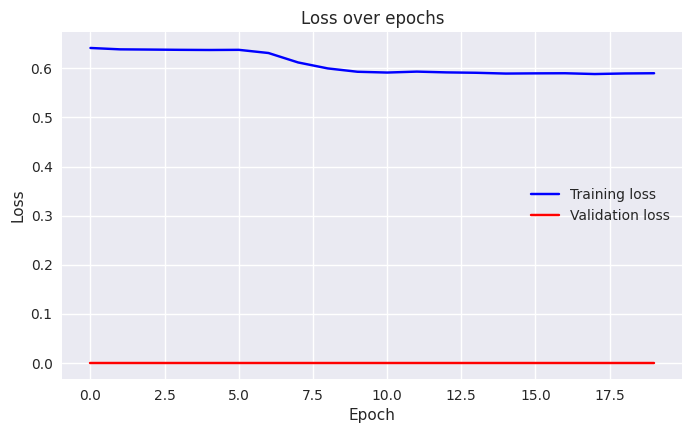

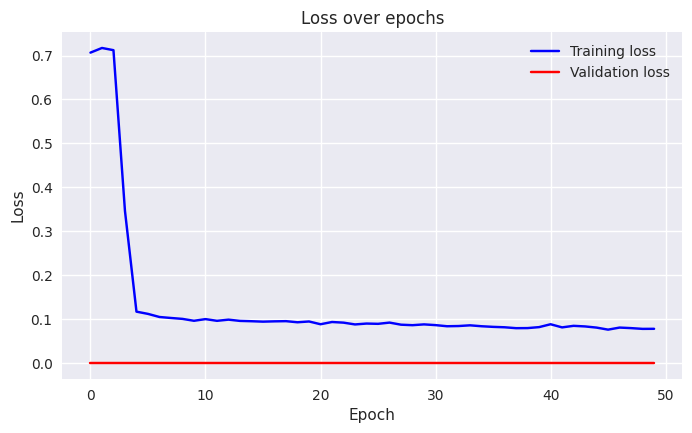

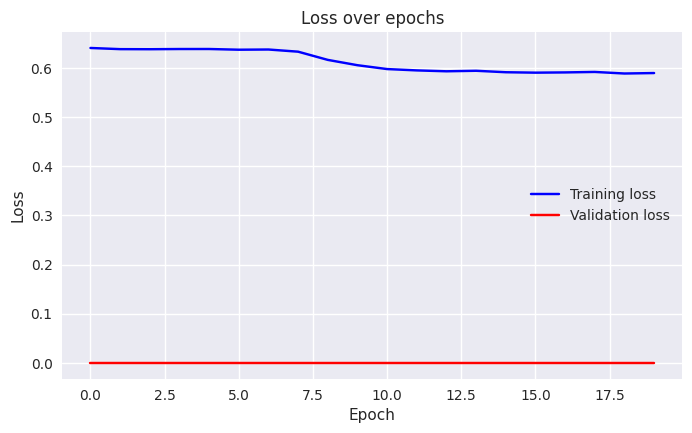

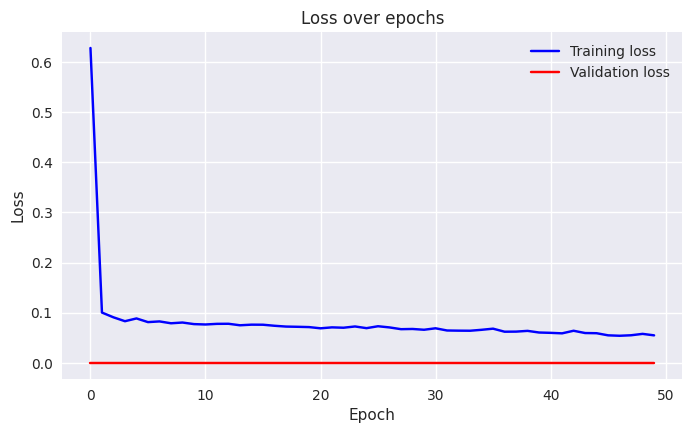

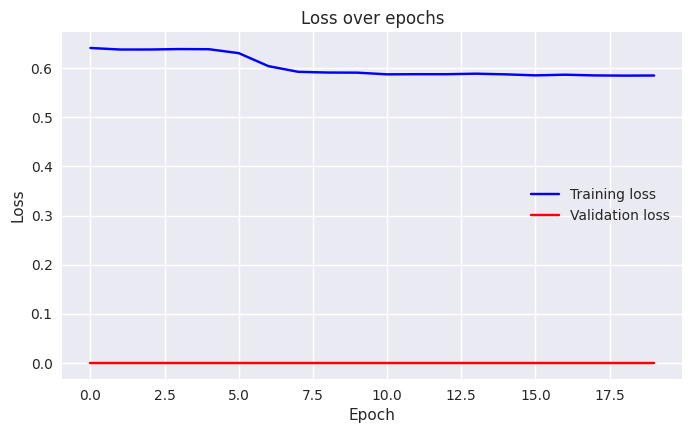

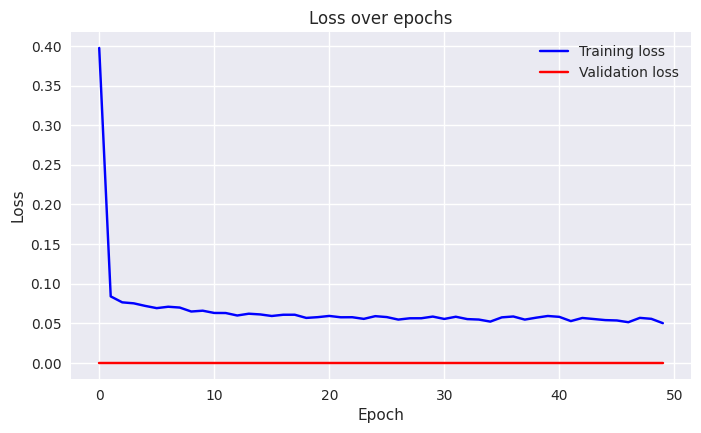

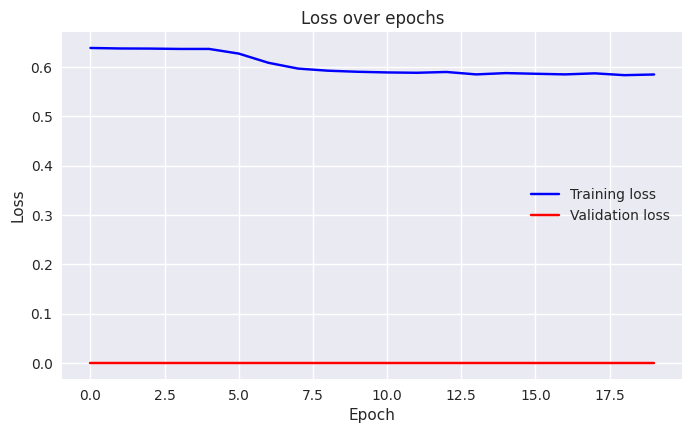

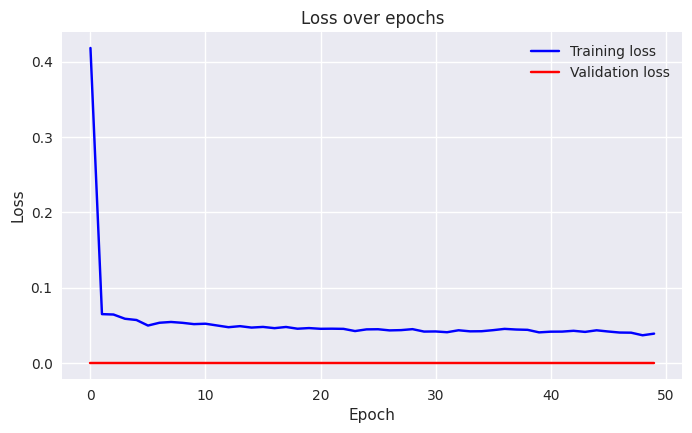

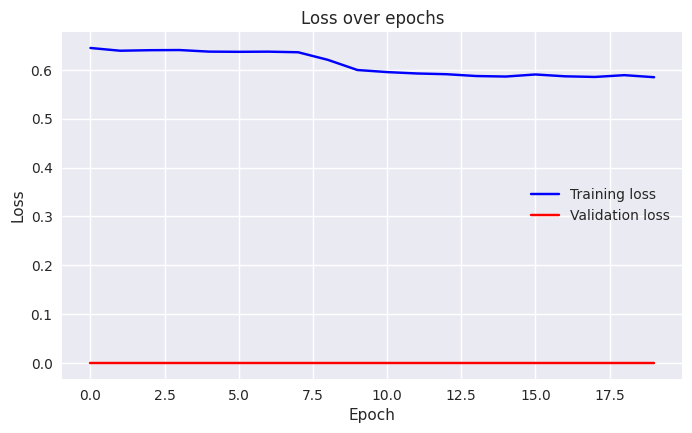

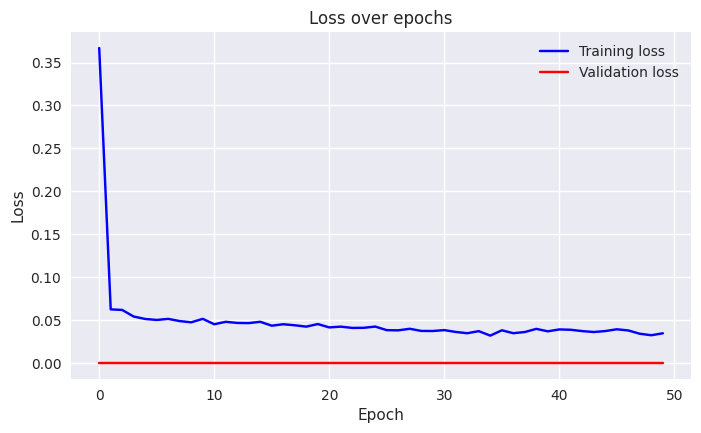

In [111]:
class NullStream:
        @staticmethod
        def write(*_): pass
        @staticmethod
        def flush(*_): pass

def print_to_stdout_and_stream(text, stream:TextIO = NullStream):
        sys.stdout.write(text)
        sys.stdout.flush()
        stream.write(text)
        stream.flush()

# DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

NUM_EXPERIMENT_TYPES = 2 # 1 - only 9, 2 - 4+9
NUM_EXPERIMENTS_PER_TYPE = 5
BATCH_SIZE = 32


with open('experiments-results.csv', mode='at', encoding="utf-8") as results_stream:
    print_to_stdout_and_stream("experiment_id,\texperiment_type,\tseed,\tbatch_size,\talpha,\ttraining set size,\ttest set size,\tm,\tl,"
                               "\tAdaDetect num epochs,\tAdaDetect final CELoss,\tAdaDetect total elements,\tAdaDetect total discoveries (ktest),\tAdaDetect v,\tAdaDetect false discoveries,\tAdaDetect fdp,"
                               "\tLR total elements,\tLR total discoveries (ktest),\tLR v,\tLR false discoveries,\tLR fdp,"
                               "\tBenchmark num epochs,\tBenchmark final CELoss,\tBenchmark total elements,\tBenchmark total discoveries (ktest),\tBenchmark v,\tBenchmark false discoveries,\tBenchmark fdp\n",
                              results_stream) 
    
    for exp_type in range(2,NUM_EXPERIMENT_TYPES+1):
        
        for i in range(NUM_EXPERIMENTS_PER_TYPE):
            
            # Print to know we started another discovery process
            exp_id = F"{exp_type}-{i}-{datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S')}"
            print_to_stdout_and_stream(F"{exp_id},"
                                       F"\t{exp_type},"
                                       F"\t{i},"
                                       F"\t{BATCH_SIZE},", results_stream)
            
            discovery_results = run_discovery(i, BATCH_SIZE, exp_type)
            
            print_to_stdout_and_stream(F"\t{discovery_results['alpha']},"
                                       F"\t{discovery_results['training_set_size']},"
                                       F"\t{discovery_results['test_set_size']},"
                                       F"\t{discovery_results['m']},"
                                       F"\t{discovery_results['l']},"
                                       F"\t{discovery_results['num_epochs']['real']},"
                                       F"\t{discovery_results['final_CELoss']['real']},"
                                       F"\t{discovery_results['total_elements']['real']},"
                                       F"\t{discovery_results['total_discoveries']['real']},"
                                       F"\t{discovery_results['v']['real']},"
                                       F"\t{discovery_results['false_discoveries']['real']},"
                                       F"\t{discovery_results['fdp']['real']},"
                                       F"\t{discovery_results['total_elements']['lr']},"
                                       F"\t{discovery_results['total_discoveries']['lr']},"
                                       F"\t{discovery_results['v']['lr']},"
                                       F"\t{discovery_results['false_discoveries']['lr']},"
                                       F"\t{discovery_results['fdp']['lr']},"
                                       F"\t{discovery_results['num_epochs']['benchmark']},"
                                       F"\t{discovery_results['final_CELoss']['benchmark']},"
                                       F"\t{discovery_results['total_elements']['benchmark']},"
                                       F"\t{discovery_results['total_discoveries']['benchmark']},"
                                       F"\t{discovery_results['v']['benchmark']},"
                                       F"\t{discovery_results['false_discoveries']['benchmark']},"
                                       F"\t{discovery_results['fdp']['benchmark']}\n", results_stream)
            
            # Reproduceability - save the model used for this discovery process
            torch.save({ 
                'model_state_dict': discovery_results["model"]["real"].state_dict(),
                'optimizer_state_dict': discovery_results["optimizer"]["real"].state_dict(),
                'loss': discovery_results["final_CELoss"]["real"],
                'benchmark_model_state_dict': discovery_results["model"]["benchmark"].state_dict(),
                'benchmark_optimizer_state_dict': discovery_results["optimizer"]["benchmark"].state_dict(),
                'benchmark_loss': discovery_results["final_CELoss"]["benchmark"],
                'lr_null_mv': discovery_results["model"]["lr"].null_mv,
                'lr_positive_mv': discovery_results["model"]["lr"].positive_mv,
            }, F"{exp_id}.pt")

print("*** All done! ***")